In [1]:
!nproc & nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-125eaf29-537f-5e5a-8a00-140ef5b42572)


'nproc' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
import os
import sys
import glob
import json
import random
from tqdm import tqdm
from pprint import pprint
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

dataset_dir = "../../../pricerunner/"
out_dir = "../../../text_data/"

In [6]:
files = glob.glob(dataset_dir+"*.json")
len(files)

245258

In [39]:
shoe_filters = [
    "shoes",
    "trainers",
    "boots", 
    "sandals",
    "flip-flops",
    "footwear",
	"heels",
	"wellingtons",
	"slippers",
]

os.makedirs(out_dir, exist_ok=True)

for file in tqdm(files):
	with open(file, encoding="utf-8") as f:
		data = json.load(f)
		crumbs = ' '.join(data["crumbs"]).lower()
		if any([x in crumbs for x in shoe_filters]):
			titles = set()
			titles.add(data["title"] + "\n")
			for merch_offers in data["offers"].values():
				for offer in merch_offers:
					titles.add(offer["title"] + "\n")
				try:
					with open(os.path.join(out_dir, os.path.basename(file).replace(".json", ".txt")), "w") as f:
						f.writelines(titles)
				except Exception:
					pass

100%|██████████| 245258/245258 [00:19<00:00, 12358.68it/s]


In [7]:
files = glob.glob(os.path.join(out_dir, "*.txt"))
len(files)

6288

In [8]:
data = defaultdict(list)
for file in files:
	with open(file) as f:
		lines = f.readlines()
		_id = os.path.basename(file).replace(".txt", "")
		for line in lines:
			data["id"].append(_id)
			data["title"].append(line)
df = pd.DataFrame(data)
df.title = df.title.str.strip()
df

,id,title
0,1194-3200019724,Sorel Unisex Kid's YOUTH LANNER RIDGE II Slipp...
1,1194-3200019724,Sorel Unisex Baby Youth Lanner Ridge II' Slipp...
2,1194-3200019724,Slippers Lanner Ridge Ii Youth
3,1194-3200019724,Sorel Youth Lanner Ridge II - Camel Brown
4,1194-3200019724,Sorel Unisex Kid's YOUTH LANNER RIDGE II Slipp...
...,...,...
78211,742-4614381,Mystim Pinwheel with Five Wheel
78212,742-4614381,Extra Spiny Spencer E-Stim Pinwheel
78213,742-4614381,MyStim Extra Spiny Spencer
78214,742-4614548,MyStim Spiny Spencer


<AxesSubplot:>

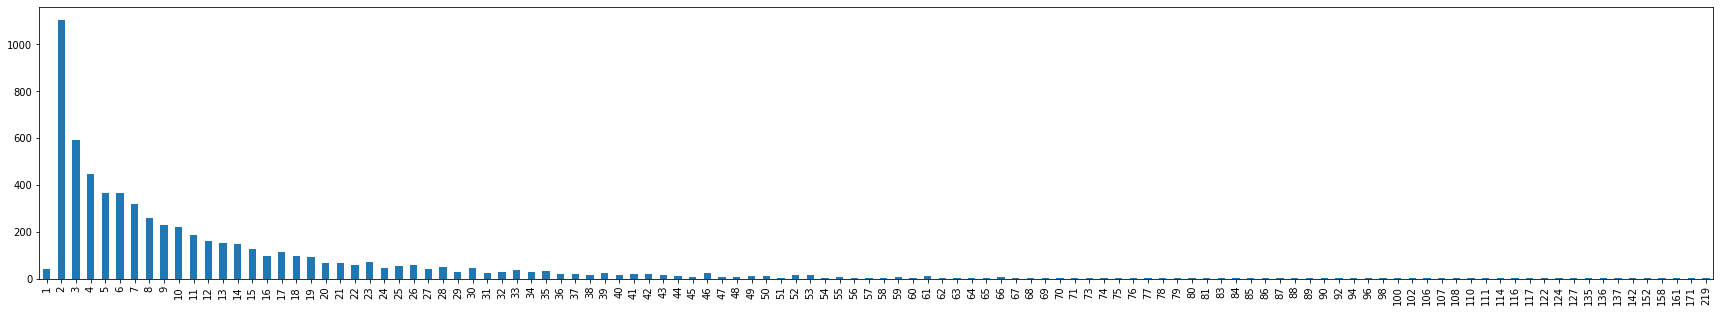

In [9]:
df.id.value_counts().value_counts().sort_index().plot.bar(figsize=(30,5))

In [18]:
max_samples = 15
min_samples = 4

retain = set()
for label, label_group in df.groupby("id"):
    if len(label_group) > max_samples:
        retain.update(random.choices(label_group.index, k=max_samples))
    elif len(label_group) >= min_samples:
        retain.update(label_group.index)

df = df.loc[retain].reset_index(drop=True)
df

,id,title
0,1194-3200019724,Sorel Unisex Kid's YOUTH LANNER RIDGE II Slipp...
1,1194-3200019724,Sorel Unisex Baby Youth Lanner Ridge II' Slipp...
2,1194-3200019724,Slippers Lanner Ridge Ii Youth
3,1194-3200019724,Sorel Youth Lanner Ridge II - Camel Brown
4,1194-3200019724,Sorel Unisex Kid's YOUTH LANNER RIDGE II Slipp...
...,...,...
42352,734-5296330,Mascot Workwear F0121 Safety shoe S3 with lace...
42353,742-4349561,Fifty Shades Darker Adrenaline Spikes Metal Pi...
42354,742-4349561,Fifty Shades of Grey Darker Adrenaline Spikes ...
42355,742-4349561,Fifty Shades Darker Adrenaline Spikes Metal Wa...


<AxesSubplot:>

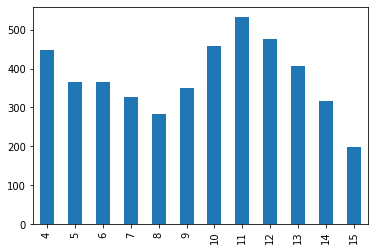

In [19]:
df.id.value_counts().value_counts().sort_index().plot.bar()

In [21]:
df.shape

(42357, 2)

In [22]:
df.id.nunique()

4526

In [25]:
df["label"] = df.id
df

,id,title,label
0,1194-3200019724,Sorel Unisex Kid's YOUTH LANNER RIDGE II Slipp...,1194-3200019724
1,1194-3200019724,Sorel Unisex Baby Youth Lanner Ridge II' Slipp...,1194-3200019724
2,1194-3200019724,Slippers Lanner Ridge Ii Youth,1194-3200019724
3,1194-3200019724,Sorel Youth Lanner Ridge II - Camel Brown,1194-3200019724
4,1194-3200019724,Sorel Unisex Kid's YOUTH LANNER RIDGE II Slipp...,1194-3200019724
...,...,...,...
42352,734-5296330,Mascot Workwear F0121 Safety shoe S3 with lace...,734-5296330
42353,742-4349561,Fifty Shades Darker Adrenaline Spikes Metal Pi...,742-4349561
42354,742-4349561,Fifty Shades of Grey Darker Adrenaline Spikes ...,742-4349561
42355,742-4349561,Fifty Shades Darker Adrenaline Spikes Metal Wa...,742-4349561


In [20]:
df.to_csv("s3://aisle3-ml-datasets/arcface/text/train/price_runner.csv", index=False)